In [60]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
dat = pd.read_csv('BRCA.csv')
dat = dat.drop(dat.columns[[0]], axis=1)
dat = dat.T
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(638, 1, 11327)


In [79]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [80]:
train_data, test_data = train_test_split(dat, test_size = 0.3,random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train data: 446
test data: 192


In [81]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
               
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [82]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(2048, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs):
        x = self.lay1(inputs)
        x = self.lay2(x)        
        x = self._residual_stack(x)
        return x 

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(2048, input_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x = self.lay1(x)
        x = self.lay2(x)
        
        return x

In [83]:
class Model(nn.Module):
    def __init__(self, input_size, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(input_size, encoder_dim, dropout)
        
        self._pre_vq_conv = nn.Linear(encoder_dim, num_embeddings)
        
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            
        self._decoder = Decoder(num_embeddings, input_size, encoder_dim, dropout)
        
    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)
        return loss, x_recon, perplexity, _, quantized

In [92]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-3, amsgrad=False)
data_variance = np.var(dat)

VQ_VAE.load_state_dict(torch.load('VQ_VAE_disc'),strict=False)
print(DEVICE)

cpu


In [86]:
EPOCH = 1
train_res_recon_error = []
train_res_perplexity = []

loss_list=[]
val_loss_list=[]
ac_list=[]

VQ_VAE.train()


for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    quantized_merge = torch.empty(0,1,64).to(DEVICE)
    for _, (inputs) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
                
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss 
        loss.backward()
        optimizer.step()
        count=count+1

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [90]:
en_lat = []
en_quantized = []
data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)

for i in range(len(dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, _, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (638, 512)
quantized_out: (638, 64)


In [30]:
latent_Z = encode_out

tsne = TSNE(early_exaggeration=50,
              learning_rate=500, 
              perplexity=50, 
              min_grad_norm=1e-7, 
              n_iter=3000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

TSNE_out: (638, 2)


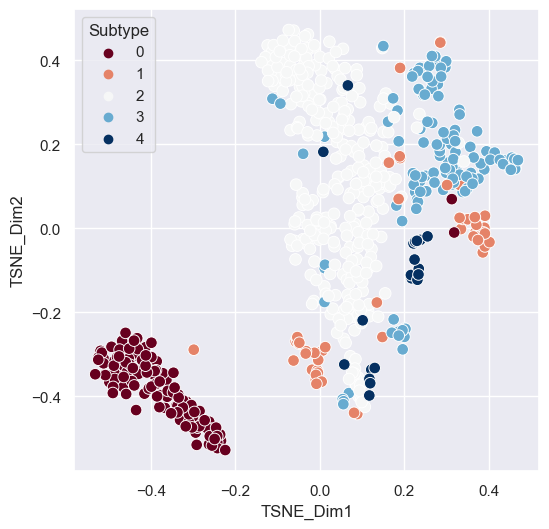

In [32]:
index = pd.read_csv('label.csv', header=0)
index = index[0 :data_num].astype(int)
label = index.values.tolist()  
True_labels = pd.DataFrame(label)
TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = True_labels
#tsne of learened feature
plt.figure(figsize=(6,6))
sns.set(style='darkgrid',context='notebook')
sns.scatterplot(data = TSNE_result, x='TSNE_Dim1', y='TSNE_Dim2',hue='Subtype',palette='RdBu',s = 70)

plt.show()

[0.48782024 0.19290492]
[6878.483  2720.0454]
pca_result: (638, 2)


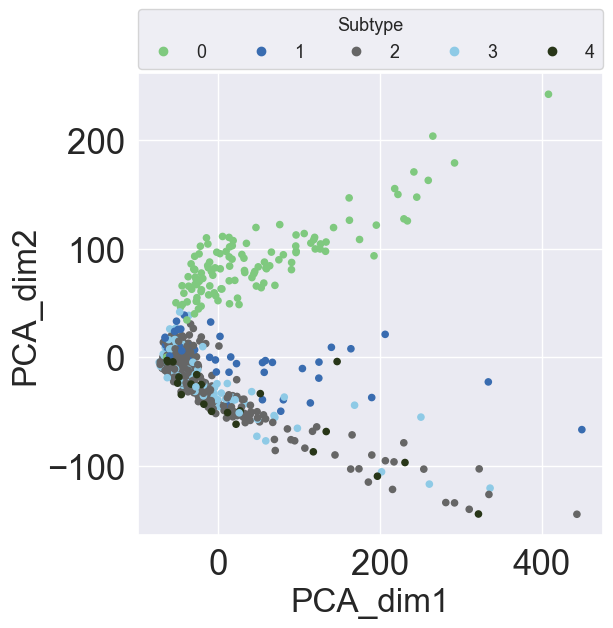

In [37]:
#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
print('pca_result:',pca_result.shape)

sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(6,6)) 
my_color = ["#7FC97F","#FDBF86","#396CB0",'#BF5C16',"#666666",'#FB8500',"#8ECAE6","#283618"]
my_cmap = ListedColormap(sns.color_palette(my_color).as_hex())
a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap,c=TSNE_result['Subtype'],s=20)

L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 13,
           fontsize = 13,
           loc = (0,1.01),
           ncol = 5,
           title="Subtype")

plt.xlabel("PCA_dim1", size=24)  
plt.ylabel("PCA_dim2", size=24)
plt.tick_params(axis='x', which='both', labelsize=25)
plt.tick_params(axis='y', which='both', labelsize=25)

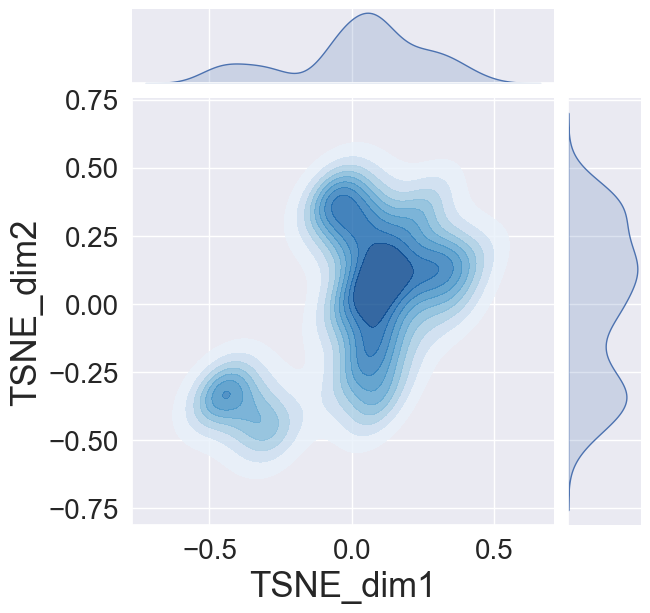

In [55]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, cmap="Blues", fill=True, kind='kde',height=6,
                 marginal_kws={"alpha":.2},thresh=0.05, alpha=.8)
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

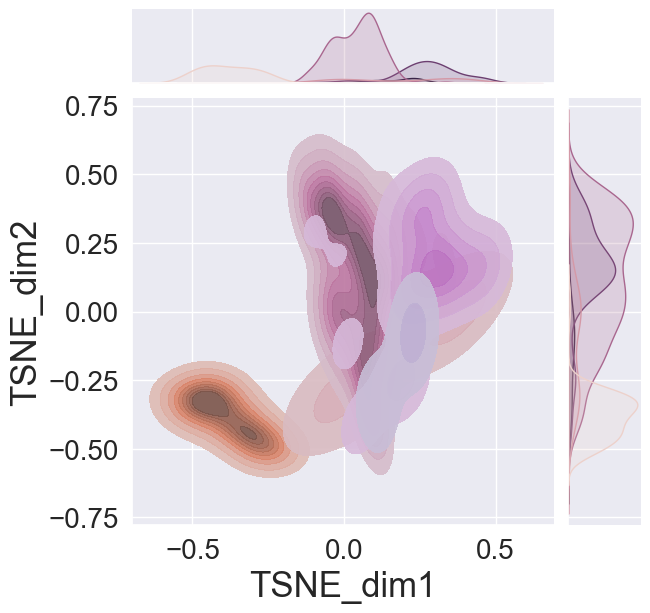

In [56]:
f = sns.jointplot(x=TSNE_result.TSNE_Dim1, y=TSNE_result.TSNE_Dim2, fill=True, kind='kde',hue=TSNE_result.Subtype,height=6,marginal_kws={"alpha":.2},thresh=0.05, alpha=.9)

f.ax_joint.legend_._visible=False
f.ax_joint.set_xlabel("TSNE_dim1",fontsize=25)
f.ax_joint.set_ylabel("TSNE_dim2",fontsize=25)
f.ax_joint.tick_params(labelsize=20)

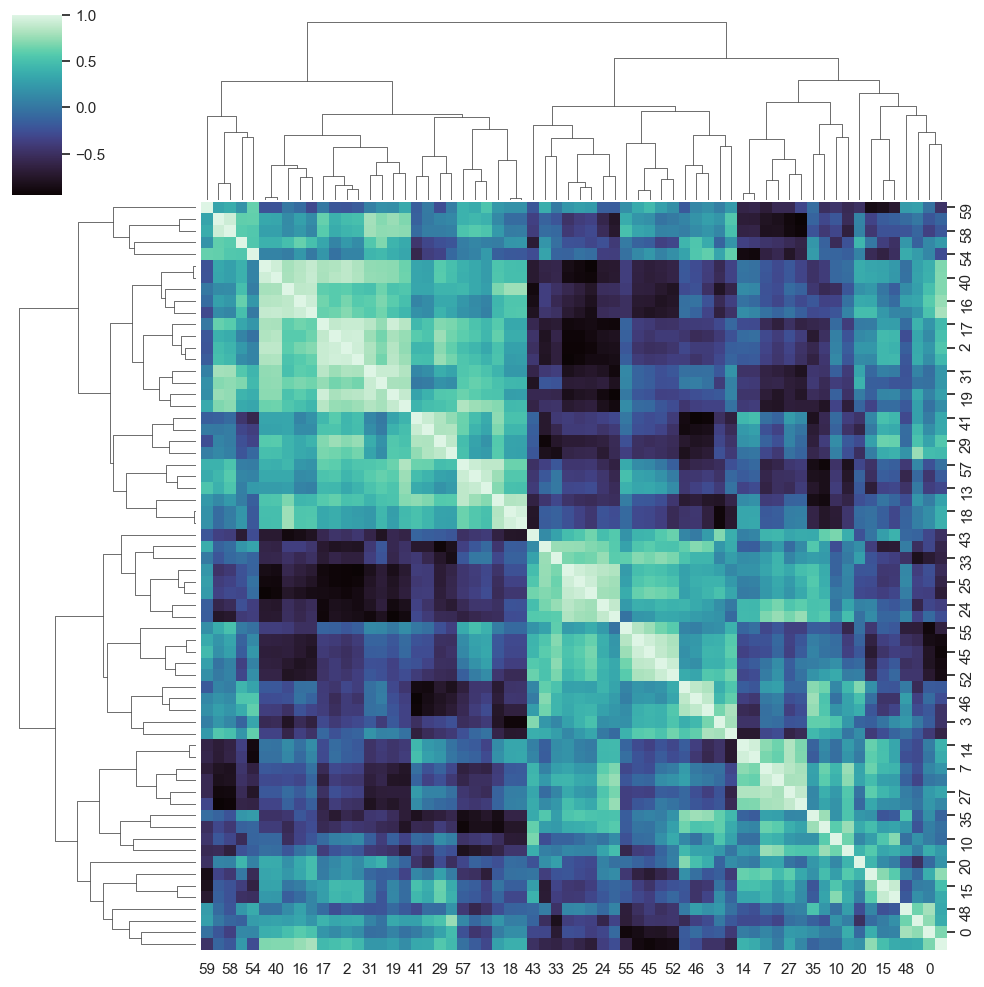

In [59]:
df = pd.DataFrame(quantized_out)
corr = df.corr(method = 'spearman')
sns.clustermap(pd.DataFrame(corr),cmap = 'mako')